<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Choosing First Stage Models in EconML Estimators

Choosing first stage models for the various EconML estimators can seem like a daunting task. However, there are several ways to choose suitable first stage models, depending on the problem you are trying to solve. In this notebook, we go through the various types of crossvalidation and hyperparameter tuning used to select the first stage models.   

In [1]:
# Imports
import numpy as np
import scipy.special
from econml.dml import LinearDML
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Data generation with quadratic treatment effect
np.random.seed(123)
n = 2000
p = 10
W = np.random.uniform(size=(n, p))
X = np.random.uniform(size=(n, 1))
true_effect = lambda x: x[:, 0] ** 2
T = W[:, 0] + W[:, 1] ** 2 + np.random.uniform(-1, 1, size=n)
Y = (
    true_effect(X) * T
    + W @ np.random.uniform(size=p)
    + np.random.uniform(-1, 1, size=n)
)
X_test = np.arange(0, 1, 0.02).reshape(-1, 1)
test_effect = true_effect(X_test)

<IPython.core.display.Javascript object>

## 1. Using cross-validated estimators as first stage models

The most straightforward way to choose a first stage model is to not choose one at all and instead let the EconML estimators do the work for you. To achieve this, you can pass in a cross-validated estimator such as `sklearn`'s `LassoCV` or `GridSearchCV` as the first stage models. The EconML estimator will internally run the cross-validation step and select the best models for the first stage. 

**Advantages:** 

* Requires little to no boilerplate code, you can just pass in a CV estimator along with a hyperparameter grid.

**Disadvantages:**

 * The EconML estimator will take longer to run due to an internal cross-validation step for computing the residuals. Further, the CV estimator will be trained on $n_{samples}/\text{cv}$ data points which might not be suitable for small datasets. 
 * Requires special CV estimator to choose among many classes of estimators (e.g. Lasso and GradientBoostingForest, see section 2.2. for workaround)

In [3]:
model_y = LassoCV(max_iter=10000)
model_t = LassoCV(max_iter=10000)
est = LinearDML(
    model_y=model_y,
    model_t=model_t,
    featurizer=PolynomialFeatures(degree=2),
    fit_cate_intercept=False,
)
est.fit(Y, T, X=X, W=W)
te_pred_lasso = est.effect(X_test)

<IPython.core.display.Javascript object>

In [4]:
first_stage = lambda: GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={"max_depth": [3, 5, None], "n_estimators": (50, 100, 200)},
    cv=2,
    n_jobs=-1,
)
est = LinearDML(
    model_y=first_stage(),
    model_t=first_stage(),
    featurizer=PolynomialFeatures(degree=2),
    linear_first_stages=False,
)
est.fit(Y, T, X=X, W=W)
te_pred_gbr = est.effect(X_test)

<IPython.core.display.Javascript object>

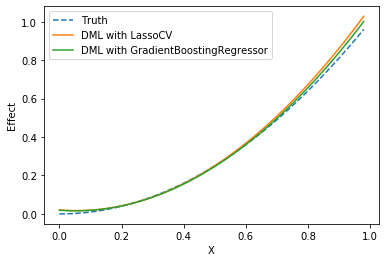

<IPython.core.display.Javascript object>

In [5]:
plt.plot(X_test, test_effect, "--", label="Truth")
plt.plot(X_test, te_pred_lasso, label="DML with LassoCV")
plt.plot(X_test, te_pred_gbr, label="DML with GradientBoostingRegressor")
plt.legend()
plt.xlabel("X")
plt.ylabel("Effect")
plt.show()

## 2. Performing first stage model selection outside of EconML

An alternative to passing in CV models to EconML is to perform model selection outside of the EconML estimators and then pass in the pre-selected models to EconML. This is the preferred method for first stage model selection due to its statistical and computational advantages.

**Advantages:** 

* Faster runtimes of the EconML estimators and more flexible selection of first stage models.

* As long as $\log(\text{#hyperparameters}) << O(n_{samples})$, this approach maintains statisical validity of the resulting inference results.

**Disadvantages:** Requires more boilerplate code and manual training, scoring and selection of the first stage models.

### 2.1. Tuning hyperparameters within the same estimator class

Here we select the best estimator within a given class (e.g. Lasso or GradientBoostingForest). This is done by conventional hyperparameter tuning. 

In [6]:
XW = np.hstack([X, W])
model_y_alpha = LassoCV(max_iter=10000).fit(XW, Y).alpha_
model_t_alpha = LassoCV(max_iter=10000).fit(XW, T).alpha_
model_y = Lasso(alpha=model_y_alpha, max_iter=10000)
model_t = Lasso(alpha=model_t_alpha, max_iter=10000)
est = LinearDML(
    model_y=model_y,
    model_t=model_t,
    featurizer=PolynomialFeatures(degree=2),
    fit_cate_intercept=False,
)
est.fit(Y, T, X=X, W=W)
te_pred_lasso = est.effect(X_test)

<IPython.core.display.Javascript object>

In [7]:
model_y = first_stage().fit(XW, Y).best_estimator_
model_t = first_stage().fit(XW, T).best_estimator_
est = LinearDML(
    model_y=model_y,
    model_t=model_t,
    featurizer=PolynomialFeatures(degree=2),
    linear_first_stages=False,
)
est.fit(Y, T, X=X, W=W)
te_pred_gbr = est.effect(X_test)

<IPython.core.display.Javascript object>

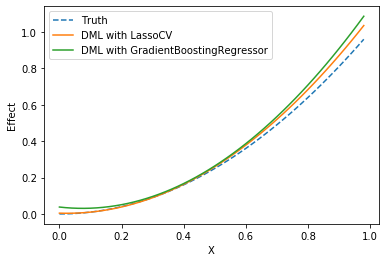

<IPython.core.display.Javascript object>

In [8]:
plt.plot(X_test, test_effect, "--", label="Truth")
plt.plot(X_test, te_pred_lasso, label="DML with LassoCV")
plt.plot(X_test, te_pred_gbr, label="DML with GradientBoostingRegressor")
plt.legend()
plt.xlabel("X")
plt.ylabel("Effect")
plt.show()

### 2.2. Choosing amongst different classes of estimators

Here we select among different classes of estimators. This is essentially a two-step process where we first do in-class parameter tuning and then we choose among the optimized models. EconML offers the `GridSearchCVList` utility class to perform this type of model selection.

In [9]:
from econml.sklearn_extensions.model_selection import GridSearchCVList

<IPython.core.display.Javascript object>

In [10]:
first_stage = lambda: GridSearchCVList(
    [Lasso(max_iter=10000), GradientBoostingRegressor()],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5, None], "n_estimators": [50, 100, 200]},
    ],
    cv=2,
)

<IPython.core.display.Javascript object>

In [11]:
model_y = first_stage().fit(XW, Y).best_estimator_
model_t = first_stage().fit(XW, T).best_estimator_
est = LinearDML(
    model_y=model_y, model_t=model_t, featurizer=PolynomialFeatures(degree=2)
)
est.fit(Y, T, X=X, W=W)
te_pred = est.effect(X_test)

<IPython.core.display.Javascript object>

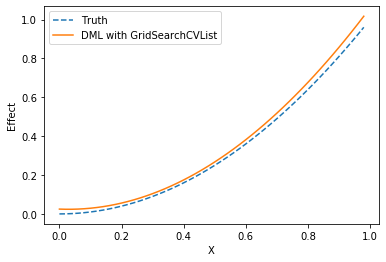

<IPython.core.display.Javascript object>

In [12]:
plt.plot(X_test, test_effect, "--", label="Truth")
plt.plot(X_test, te_pred, label="DML with GridSearchCVList")
plt.legend()
plt.xlabel("X")
plt.ylabel("Effect")
plt.show()